In [1]:
from scipy.stats import beta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle

plt.style.use('ggplot')
%matplotlib inline

# Emperical Bayes on Kidney Stone Data



In [2]:
incidence = pd.read_pickle('data/kidney_incidence.pkl')
incidence.head()

,County,FIPS,Rate_per_100k,lower_95,upper_95,average_annual_count,trend,5_yr_trend,lower_95_ci_1,upper_95_ci_1
1,"Cass County, Illinois(6,10)",17017,41.1,28.0,58.5,7,rising,35.1,19.0,53.4
2,"Union County, Florida(6,10)",12125,38.7,26.6,54.9,7,stable,-16.9,-37.4,10.4
3,"Greene County, Illinois(6,10)",17061,37.5,24.7,54.9,6,stable,28.7,-19.6,106.1
4,"Benton County, Mississippi(6,10)",28009,36.6,21.2,59.1,4,stable,23.4,-1.4,54.4
5,"Hamilton County, Illinois(6,10)",17065,36.3,22.1,57.2,4,stable,2.5,-43.0,84.2


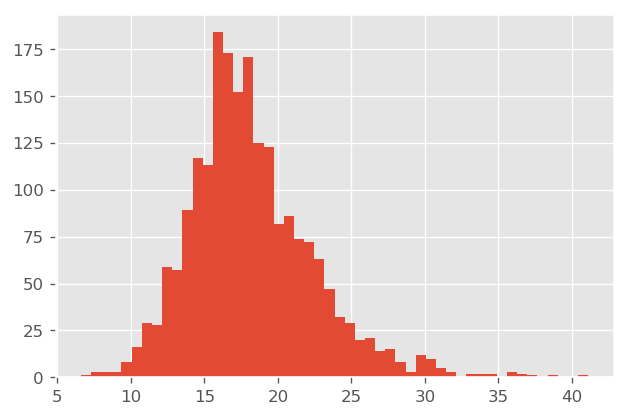

In [3]:
plt.figure(dpi=120)
plt.hist(incidence['Rate_per_100k'], bins=50);

Had some problems pulling population data for the appropriate years. We will use rate per 100k and average annual count to infer the population. This isn't perfect because the rate is age adjusted.

In [4]:
incidence['population'] = (100000*incidence['average_annual_count']/incidence['Rate_per_100k']).astype(int)

From the graph above, it looks like the rate of kidney cancer is around 16 out of 100k people when averaged over the entire US. Put another way, the probability that a randomly chosen person develops kidney cancer is approximately 0.00016. We can estimate this more precisely using the sample mean:

In [5]:
average_rate = (incidence['population'] * incidence['Rate_per_100k']).sum()/(100000*incidence['population'].sum())
average_rate

0.00016387736201837217

## Comparison with the average

The graph below shows how the kidney cancer rates in different counties compare to the overall average kidney cancer rate. Notice that the highest and lowest incidence of cancer rates occur to the left of this graph -- i.e. where the populations are small. These are the counties that are most susceptible to fluctuations in the cancer rate. As we move to larger and larger counties, the populations move closer to the overall average. 

In an extreme example, a county with only 10 people, one person being diagonosed with kidney cancer would mean 10% of the county have kidney cancer (i.e. a rate of 10000 per 100k!), whereas a county of 10 where noone was diagnosed would have a rate of 0.

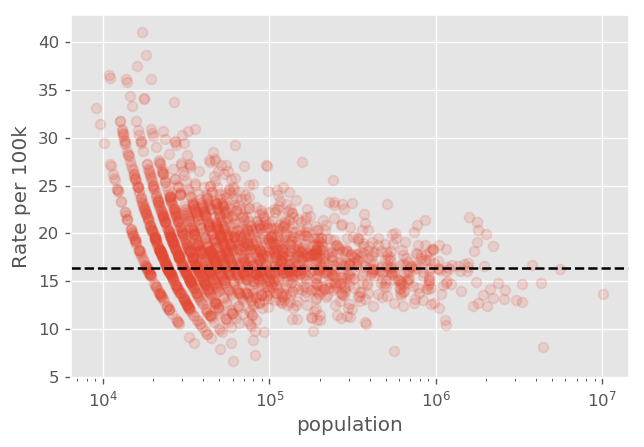

In [6]:
plt.figure(dpi=120)
plt.semilogx(incidence['population'], incidence['Rate_per_100k'], marker='o', linestyle='None', alpha=0.15)
plt.xlabel('population')
plt.ylabel('Rate per 100k')
plt.gca().axhline(average_rate*1e5, c='k', linestyle='--');

For this distribution, the method of moments doesn't give particularly meaningful results (it turns out that no beta distribution can match both the mean _and_ variance of the data). We will use the `beta.fit` method to esimate the parameters for us. 

In [7]:
# We only want the first two parameters
alpha0, beta0, *_ = beta.fit(incidence['Rate_per_100k']/1e5, floc=0., fscale=1.)

In [8]:
print(f'The best fit parameters are alpha={alpha0}, beta={beta0}')

The best fit parameters are alpha=19.366567948095202, beta=106389.18721541032


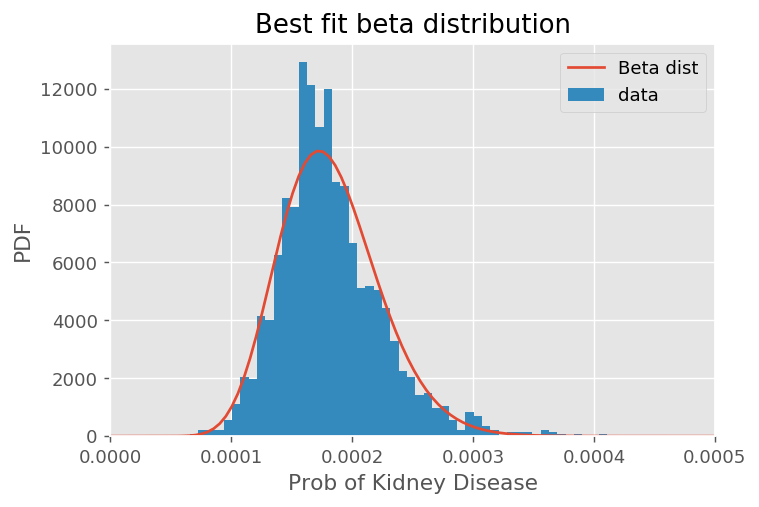

In [9]:
plt.figure(dpi=130)
X = np.linspace(0, 0.001, 200)
plt.plot(X, beta.pdf(X, a=alpha0, b=beta0, loc=0, scale=1), label='Beta dist')
plt.hist(incidence['Rate_per_100k']/100000, bins=50, normed=True, label='data')
plt.xlim(0,5e-4)
plt.title('Best fit beta distribution')
plt.legend()
plt.xlabel('Prob of Kidney Disease')
plt.ylabel('PDF');

In [10]:
incidence['shrinkage'] = 100000*(incidence['average_annual_count'] + alpha0)/(incidence['population'] + beta0 + alpha0)

Below we show the data after it has been "shrunk" toward $\alpha_0/(\alpha_0 + \beta_0)$, shown as the dashed line. For comparison, the average rate has been shown as a dotted line.

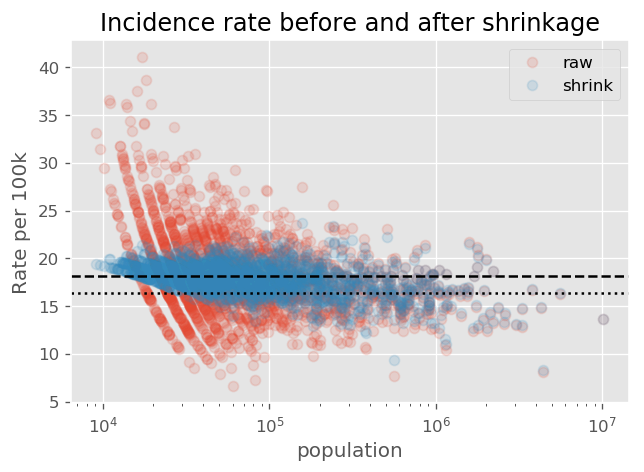

In [11]:
plt.figure(dpi=120)
plt.semilogx(incidence['population'], incidence['Rate_per_100k'], marker='o', 
             linestyle='None', alpha=0.15, label='raw')
plt.semilogx(incidence['population'], incidence['shrinkage'], marker='o', 
             linestyle='None', alpha=0.15, label='shrink')
plt.legend()
plt.title('Incidence rate before and after shrinkage')
plt.xlabel('population')
plt.ylabel('Rate per 100k')
plt.gca().axhline(average_rate*100000, c='k', linestyle=':')
plt.gca().axhline(alpha0/(alpha0 + beta0)*100000, c='k', linestyle='--');